# Computer Vision and Deep Learning - Laboratory 6
 
Congratulations, you made it till the last laboratory of the semester. This laboratory will be a bit different: it contains two parts and you can __choose__ at your own preference which of them you want to solve.  Of course, you can choose to solve both of them.
 
The first part is related to _visualization_, while the second one is related to sequence models and vision transformers.


In [1]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Part 1. Visualizing what neural networks learn



For this part you can either work with a neural network that you trained (perhaps for your project), or with a pre-trained model from tensorflow.
 
For illustration purposes, I will load the Resnet network, pre-trained on Imagenet and, of course, an image of a cat.


In [1]:
!wget -O cat.jpg 'https://img.freepik.com/free-photo/cat-white-background_155003-20502.jpg?size=626&ext=jpg'

--2021-12-30 23:07:22--  https://img.freepik.com/free-photo/cat-white-background_155003-20502.jpg?size=626&ext=jpg
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving img.freepik.com (img.freepik.com)... 2a02:26f0:1500:186::30ec, 2a02:26f0:1500:18f::30ec, 92.123.229.182
Connecting to img.freepik.com (img.freepik.com)|2a02:26f0:1500:186::30ec|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25662 (25K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>]  25.06K  --.-KB/s    in 0.03s   

2021-12-30 23:07:22 (804 KB/s) - ‘cat.jpg’ saved [25662/25662]



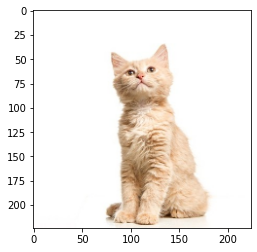

In [2]:
img = cv2.imread('cat.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

In [3]:
resnet50_model = ResNet50(weights='imagenet')
resnet50_model.summary()
#tf.keras.utils.plot_model(resnet50_model, show_shapes=True, show_dtype=True)

2021-12-30 23:16:21.311888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 23:16:21.379549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 23:16:21.380075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-30 23:16:21.381895: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

## Display the filters in the first and second convolutional layer

Get the filters in the first and second convolutional layers and plot them. The filters in the first convolutional layer should be displayed as color images, while for the filters in the second layer you should display each channel individually as a grayscale image.

Identify the names of these two layers and then use _layer.get_weights()_ to access the values of the filters.

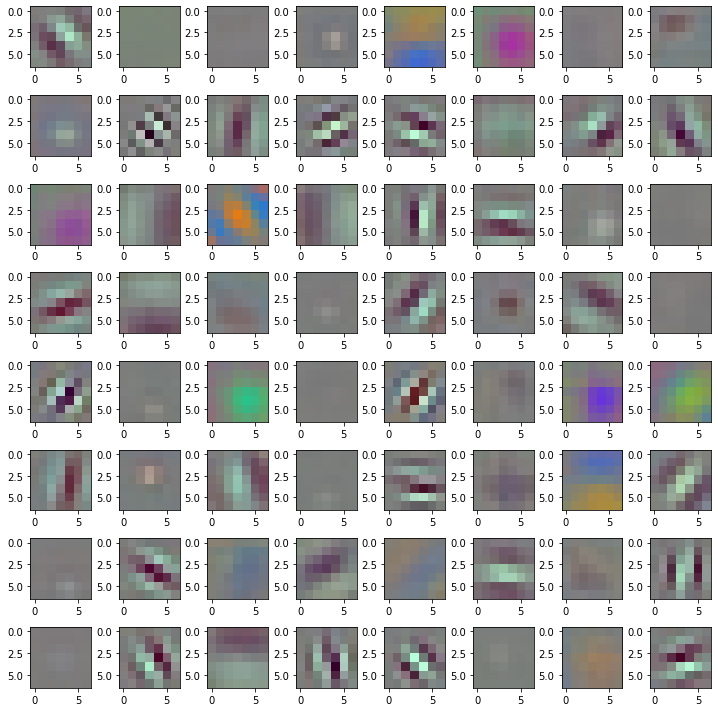

In [14]:
layer1_weights = resnet50_model.get_layer("conv1_conv").get_weights()[0]
mn = np.min(layer1_weights)
layer1_weights -= mn
mx = np.max(layer1_weights)
layer1_weights /= mx
layer1_weights *= 255
layer1_weights = layer1_weights.astype(int)
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(layer1_weights[:, :, :, i])
plt.tight_layout()
plt.show()

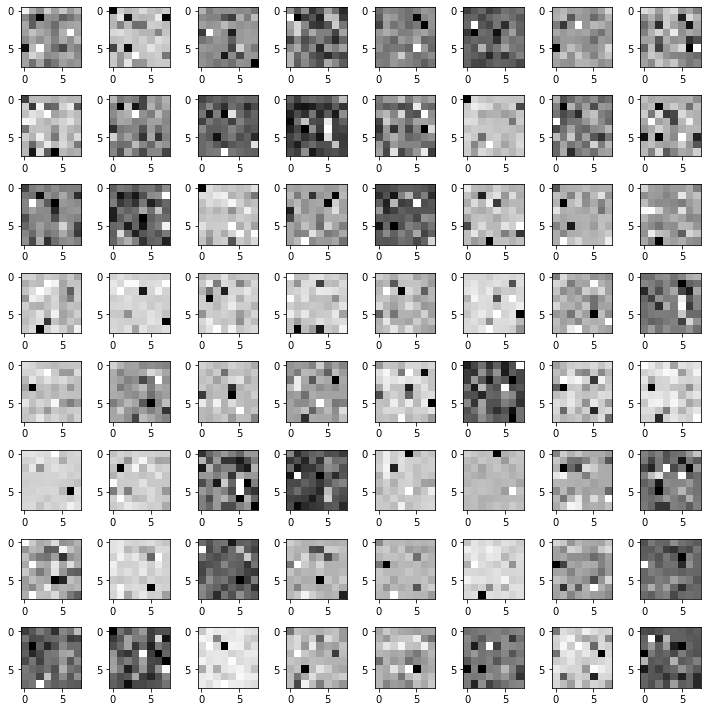

In [24]:
layer1_weights = resnet50_model.get_layer("conv2_block1_1_conv").get_weights()[0].reshape((8, 8, 64))
mn = np.min(layer1_weights)
layer1_weights -= mn
mx = np.max(layer1_weights)
layer1_weights /= mx
layer1_weights *= 255
layer1_weights = layer1_weights.astype(int)
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(layer1_weights[:, :, i], cmap="gray")
plt.tight_layout()
plt.show()

## Saliency map via image occlusions
 
This visualization technique will output a heatmap which will highlight the regions that the model finds important when predicting a certain class.
 
The implementation is straightforward: you just slide an occluding patch over the input image, and, for each position of the patch, feed the occluded image to the network and store the predictions (probas) of the model.
 
Finally, display (as a heatmap) the probability of the correct class.


[[('n02123394', 'Persian_cat', 0.87214637), ('n02123045', 'tabby', 0.06020731), ('n02123159', 'tiger_cat', 0.008770716), ('n02124075', 'Egyptian_cat', 0.008622404), ('n04553703', 'washbasin', 0.0037412366)]]
(289, 1000)
283


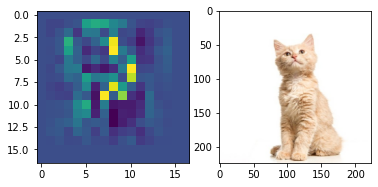

In [33]:
def compute_saliency_map(model, img, patch_size, stride):
    """
    Succesivelly occlude the input image with a gray square patch of size patch_size.
    When sliding the patch over the input image a step equal to stride is used.
    """

    padded_image = np.pad(img, ((patch_size//2, patch_size//2), (patch_size//2, patch_size//2), (0, 0)), mode="edge")

    # TODO your code here: compute the size of the output
    wo = int((img.shape[1] + 2*(patch_size//2))/stride + 1) # the width of the output heatmap
    ho = int((img.shape[0] + 2*(patch_size//2))/stride + 1) # the height of the output heatmap
    heatmap = np.zeros((ho, wo), dtype=np.float32)

    true_class = tf.keras.backend.get_value(model(np.expand_dims(tf.keras.applications.resnet50.preprocess_input(img), 0)))
    print(tf.keras.applications.resnet50.decode_predictions(true_class))
    true_class = np.argmax(true_class, axis=-1)[0]
    batch = []

    for y in range(0, ho, stride):
        for x in range(0, wo, stride):
            patched_image = np.copy(img)
            patched_image[y*stride-patch_size//2:y*stride+patch_size//2,x*stride-patch_size//2:x*stride+patch_size//2, :] = 128
            batch.append(patched_image)
    pred = model.predict(np.asarray(batch), batch_size=32)
    print(pred.shape)
    print(true_class)
    scores = pred[:, true_class]
    heatmap = np.reshape(scores, (int(np.sqrt(scores.shape[0])), int(np.sqrt(scores.shape[0]))))
    return heatmap

heatmap = compute_saliency_map(resnet50_model, img, 32, 4)
# mn = np.min(heatmap)
# mx = np.max(heatmap)
# heatmap -= mn
# heatmap /= (mx-mn)
# heatmap *= 255
# heatmap = heatmap.astype(int)
plt.subplot(1, 2, 1)
plt.imshow(heatmap)
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.show()

## Saliency maps via image derivative
 
This type of visualization tries to determine the pixels that contributed the most in the final classification.
The main idea is to compute the derivative of the scores with respect to the input image. This derivative can be seen as a class saliency map for the input image (its magnitude tells us what pixels should be modified to change the class score the most).
 
You can use a [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) to compute the gradients.

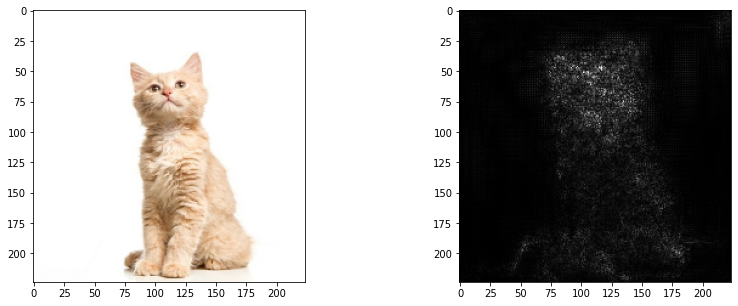

In [39]:
import tensorflow.keras as keras

def compute_saliency_map(model, img):
  
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    img = tf.Variable(img, dtype=float)

    with tf.GradientTape() as tape:
        pred = model(img, training=False)
        loss = pred[0, np.argmax(pred, axis=-1)[0]]
        grads = tape.gradient(loss, img)
        abs_grad = np.abs(grads)
        max_abs_grad = np.max(abs_grad, axis=3)

        # TODO your code here: normalize to range between 0 and 1
        mn = np.min(max_abs_grad)
        grad_norm = (max_abs_grad - mn)/(np.max(max_abs_grad) - mn)
    return grad_norm


model = tf.keras.applications.mobilenet_v2.MobileNetV2()
saliency_map = compute_saliency_map(model, img)

fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].imshow(img)
ax[1].imshow(saliency_map[0, :, :],cmap="gray")

## t-SNE visualization (optional)

You can use the ImageNetes Apply t-SNE visualization on the last layer of the network that you chose.
You can use the [T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) module from sklean library.

To create this visualization, you will need several images and their ground truth class. You could use some images from [imagenette](https://github.com/fastai/imagenette).

Feed the images through your model and save the activation maps of the layer just before the classification layer (create a new model starting from the pre-trained architecture that you used and set that layer as the input). Then, use t-SNE visualization to view the classes (the colors of the points should be determined by the class of those images).

# Deep-dream

Follow this [tutorial](https://www.tensorflow.org/tutorials/generative/deepdream) related to DeepDream.

In [2]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

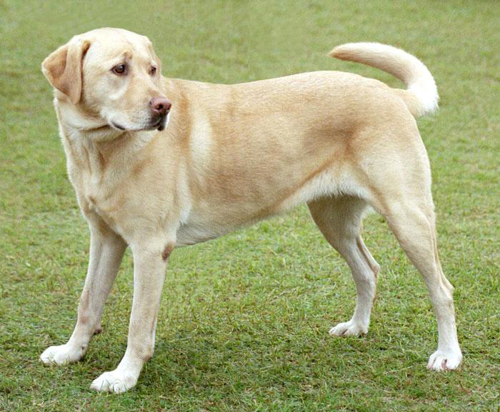

In [17]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)


In [5]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [6]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


In [7]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)


In [8]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [9]:
deepdream = DeepDream(dream_model)

In [10]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

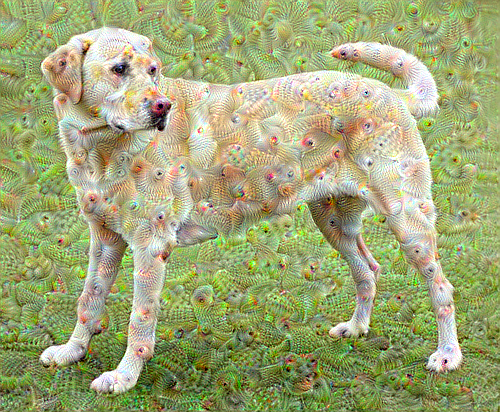

In [18]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)


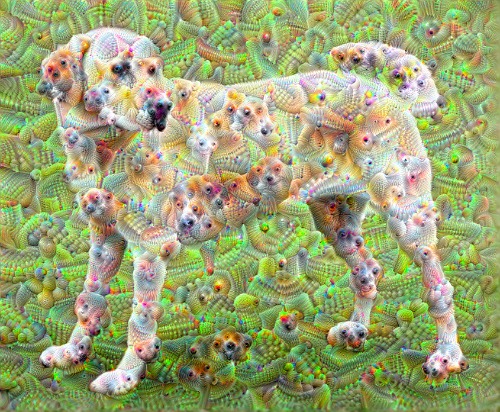

85.00646424293518


In [19]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
print(end-start)